# 01 - Data Analysis and Preparation

This notebook covers the following tasks:

1. Perform exploratory data analysis and visualization.
2. Prepare the data for the ML task in BigQuery.
3. Generate and fix a ` TFDV schema` for the source data.
4. Create a `Vertex Dataset resource` dataset.


## Dataset

The [Chicago Taxi Trips](https://pantheon.corp.google.com/marketplace/details/city-of-chicago-public-data/chicago-taxi-trips) dataset is one of [public datasets hosted with BigQuery](https://cloud.google.com/bigquery/public-data/), which includes taxi trips from 2013 to the present, reported to the City of Chicago in its role as a regulatory agency. The `taxi_trips` table size is 70.72 GB and includes more than 195 million records. The dataset includes information about the trips, like pickup and dropoff datetime and location, passengers count, miles travelled, and trip toll. 

The ML task is to predict whether a given trip will result in a tip > 20%.

## Setup

### Import libraries

In [1]:
import os
import pandas as pd
import tensorflow as tf
import tensorflow_data_validation as tfdv
from google.cloud import bigquery
import matplotlib.pyplot as plt

from google.cloud import aiplatform as vertex_ai
from google.cloud import aiplatform_v1beta1 as vertex_ai_beta

### Setup Google Cloud project

In [2]:
PROJECT = '175728527123' # Change to your project id.
REGION = 'us-west1-b' # Change to your region.

if PROJECT == "" or PROJECT is None or PROJECT == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT = shell_output[0]
    
print("Project ID:", PROJECT)
print("Region:", REGION)

Project ID: 175728527123
Region: us-west1-b


### Set configurations

In [3]:
BQ_DATASET_NAME = 'playground_us' # Change to your BQ dataset name.
BQ_TABLE_NAME = 'chicago_taxitrips_prep'
BQ_LOCATION = 'US'

DATASET_DISPLAY_NAME = 'chicago-taxi-tips'

RAW_SCHEMA_DIR = 'src/raw_schema'

## 1. Explore the data in BigQuery

In [4]:
%%bigquery data

SELECT 
    CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS string) AS trip_dayofweek, 
    FORMAT_DATE('%A',cast(trip_start_timestamp as date)) AS trip_dayname,
    COUNT(*) as trip_count,
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
    EXTRACT(YEAR FROM trip_start_timestamp) = 2015 
GROUP BY
    trip_dayofweek,
    trip_dayname
ORDER BY
    trip_dayofweek
;

Downloading: 100%|██████████| 7/7 [00:01<00:00,  4.01rows/s]


In [5]:
data

,trip_dayofweek,trip_dayname,trip_count
0,1,Sunday,4141154
1,2,Monday,4105900
2,3,Tuesday,4378805
3,4,Wednesday,4542810
4,5,Thursday,4918190
5,6,Friday,5289830
6,7,Saturday,5009186


<AxesSubplot:xlabel='trip_dayname'>

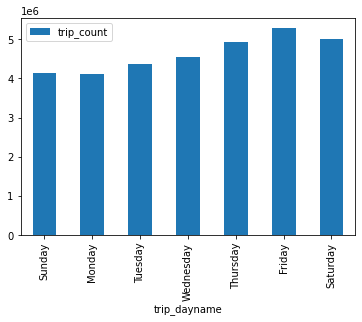

In [6]:
data.plot(kind='bar', x='trip_dayname', y='trip_count')

## 2. Create data for the ML task

We add a `ML_use` column for pre-splitting the data, where 80% of the datsa items are set to `UNASSIGNED` while the other 20% is set to `TEST`.

This column is used during training (custom and AutoML) to split the dataset for training and test.

In the training phase, the `UNASSIGNED` are split into `train` and `eval`. The `TEST` split is will be used for the final model validation.

### Create destination BigQuery dataset

In [7]:
!bq --location=US mk -d \
$PROJECT:$BQ_DATASET_NAME

BigQuery error in mk operation: Dataset '175728527123:playground_us' already
exists.


In [8]:
sample_size = 1000000
year = 2020

In [9]:

sql_script = '''
CREATE OR REPLACE TABLE `@PROJECT.@DATASET.@TABLE` 
AS (
    WITH
      taxitrips AS (
      SELECT
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        payment_type,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        tips,
        fare
      FROM
        `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      WHERE 1=1 
      AND pickup_longitude IS NOT NULL
      AND pickup_latitude IS NOT NULL
      AND dropoff_longitude IS NOT NULL
      AND dropoff_latitude IS NOT NULL
      AND trip_miles > 0
      AND trip_seconds > 0
      AND fare > 0
      AND EXTRACT(YEAR FROM trip_start_timestamp) = @YEAR
    )

    SELECT
      trip_start_timestamp,
      EXTRACT(MONTH from trip_start_timestamp) as trip_month,
      EXTRACT(DAY from trip_start_timestamp) as trip_day,
      EXTRACT(DAYOFWEEK from trip_start_timestamp) as trip_day_of_week,
      EXTRACT(HOUR from trip_start_timestamp) as trip_hour,
      trip_seconds,
      trip_miles,
      payment_type,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(pickup_longitude, pickup_latitude), 0.1)
      ) AS pickup_grid,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0.1)
      ) AS dropoff_grid,
      ST_Distance(
          ST_GeogPoint(pickup_longitude, pickup_latitude), 
          ST_GeogPoint(dropoff_longitude, dropoff_latitude)
      ) AS euclidean,
      CONCAT(
          ST_AsText(ST_SnapToGrid(ST_GeogPoint(pickup_longitude,
              pickup_latitude), 0.1)), 
          ST_AsText(ST_SnapToGrid(ST_GeogPoint(dropoff_longitude,
              dropoff_latitude), 0.1))
      ) AS loc_cross,
      IF((tips/fare >= 0.2), 1, 0) AS tip_bin,
      IF(RAND() <= 0.8, 'UNASSIGNED', 'TEST') AS ML_use
    FROM
      taxitrips
    LIMIT @LIMIT
)
'''

In [10]:
sql_script = sql_script.replace(
    '@PROJECT', PROJECT).replace(
    '@DATASET', BQ_DATASET_NAME).replace(
    '@TABLE', BQ_TABLE_NAME).replace(
    '@YEAR', str(year)).replace(
    '@LIMIT', str(sample_size))

In [11]:
print(sql_script)


CREATE OR REPLACE TABLE `175728527123.playground_us.chicago_taxitrips_prep` 
AS (
    WITH
      taxitrips AS (
      SELECT
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        payment_type,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        tips,
        fare
      FROM
        `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      WHERE 1=1 
      AND pickup_longitude IS NOT NULL
      AND pickup_latitude IS NOT NULL
      AND dropoff_longitude IS NOT NULL
      AND dropoff_latitude IS NOT NULL
      AND trip_miles > 0
      AND trip_seconds > 0
      AND fare > 0
      AND EXTRACT(YEAR FROM trip_start_timestamp) = 2020
    )

    SELECT
      trip_start_timestamp,
      EXTRACT(MONTH from trip_start_timestamp) as trip_month,
      EXTRACT(DAY from trip_start_timestamp) as trip_day,
      EXTRACT(DAYOFWEEK from trip_start_timestamp) as trip_day_of_week,
      EXTRACT(HOUR from trip_start_tim

In [12]:
bq_client = bigquery.Client(project=PROJECT, location=BQ_LOCATION)
job = bq_client.query(sql_script)
_ = job.result()

In [13]:
%%bigquery --project {PROJECT}

SELECT ML_use, COUNT(*)
FROM playground_us.chicago_taxitrips_prep # Change to your BQ dataset and table names.
GROUP BY ML_use

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.24rows/s]


,ML_use,f0_
0,TEST,200276
1,UNASSIGNED,799724


### Load a sample data to a Pandas DataFrame

In [14]:
%%bigquery sample_data --project {PROJECT}

SELECT * EXCEPT (trip_start_timestamp, ML_use)
FROM playground_us.chicago_taxitrips_prep # Change to your BQ dataset and table names.

Downloading: 100%|██████████| 1000000/1000000 [00:01<00:00, 520792.18rows/s]


In [15]:
sample_data.head().T

,0,1,2,3,4
trip_month,2,2,2,2,2
trip_day,10,10,7,14,26
trip_day_of_week,2,2,6,6,4
trip_hour,17,17,11,10,8
trip_seconds,621,1093,229,120,660
trip_miles,1.1,0.75,0.49,0.4,1.71
payment_type,Credit Card,Cash,Cash,Credit Card,Cash
pickup_grid,POINT(-87.6 42),POINT(-87.6 42),POINT(-87.6 42),POINT(-87.6 42),POINT(-87.6 42)
dropoff_grid,POINT(-87.6 42),POINT(-87.6 42),POINT(-87.6 42),POINT(-87.6 42),POINT(-87.6 42)
euclidean,0.0,0.0,0.0,0.0,0.0


In [16]:
sample_data

,trip_month,trip_day,trip_day_of_week,trip_hour,trip_seconds,trip_miles,payment_type,pickup_grid,dropoff_grid,euclidean,loc_cross,tip_bin
0,2,10,2,17,621,1.10,Credit Card,POINT(-87.6 42),POINT(-87.6 42),0.000000,POINT(-87.6 42)POINT(-87.6 42),1
1,2,10,2,17,1093,0.75,Cash,POINT(-87.6 42),POINT(-87.6 42),0.000000,POINT(-87.6 42)POINT(-87.6 42),0
2,2,7,6,11,229,0.49,Cash,POINT(-87.6 42),POINT(-87.6 42),0.000000,POINT(-87.6 42)POINT(-87.6 42),0
3,2,14,6,10,120,0.40,Credit Card,POINT(-87.6 42),POINT(-87.6 42),0.000000,POINT(-87.6 42)POINT(-87.6 42),0
4,2,26,4,8,660,1.71,Cash,POINT(-87.6 42),POINT(-87.6 42),0.000000,POINT(-87.6 42)POINT(-87.6 42),0
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2,15,7,11,1298,4.98,Prcard,POINT(-87.8 41.9),POINT(-87.8 41.9),0.000000,POINT(-87.8 41.9)POINT(-87.8 41.9),0
999996,5,22,6,9,120,0.50,Cash,POINT(-87.8 41.9),POINT(-87.8 41.9),0.000000,POINT(-87.8 41.9)POINT(-87.8 41.9),0
999997,9,16,4,17,579,0.81,Prcard,POINT(-87.8 41.9),POINT(-87.8 41.9),2700.670714,POINT(-87.8 41.9)POINT(-87.8 41.9),0
999998,5,14,5,9,842,3.68,Prcard,POINT(-87.8 41.9),POINT(-87.8 41.9),2700.670714,POINT(-87.8 41.9)POINT(-87.8 41.9),0


In [17]:
sample_data.tip_bin.value_counts()

0    636196
1    363804
Name: tip_bin, dtype: int64

<AxesSubplot:>

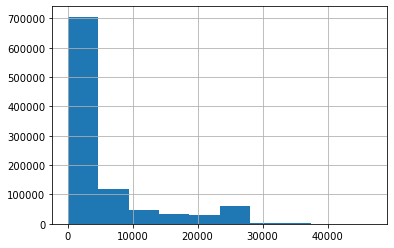

In [18]:
sample_data.euclidean.hist()

## 3. Generate raw data schema

The [TensorFlow Data Validation (TFDV)](https://www.tensorflow.org/tfx/data_validation/get_started) data schema will be used in:
1. Identify the raw data types and shapes in the data transformation.
2. Create the serving input signature for the custom model.
3. Validate the new raw training data in the TFX pipeline.

In [19]:
stats = tfdv.generate_statistics_from_dataframe(
    dataframe=sample_data,
    stats_options=tfdv.StatsOptions(
        label_feature='tip_bin',
        weight_feature=None,
        sample_rate=1,
        num_top_values=50
    )
)

In [20]:
tfdv.visualize_statistics(stats)

In [21]:
schema = tfdv.infer_schema(statistics=stats)
tfdv.display_schema(schema=schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'trip_month',INT,required,,-
'trip_day',INT,required,,-
'trip_day_of_week',INT,required,,-
'trip_hour',INT,required,,-
'trip_seconds',INT,required,,-
'trip_miles',FLOAT,required,,-
'payment_type',STRING,required,,'payment_type'
'pickup_grid',STRING,required,,'pickup_grid'
'dropoff_grid',STRING,required,,'dropoff_grid'


/opt/conda/lib/python3.7/site-packages/tensorflow_data_validation/utils/display_util.py:151: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Values
Domain,
'payment_type',"'Cash', 'Credit Card', 'Dispute', 'Mobile', 'No Charge', 'Prcard', 'Prepaid', 'Unknown'"
'pickup_grid',"'POINT(-87.5 41.7)', 'POINT(-87.6 41.7)', 'POINT(-87.6 41.8)', 'POINT(-87.6 41.9)', 'POINT(-87.6 42)', 'POINT(-87.7 41.7)', 'POINT(-87.7 41.8)', 'POINT(-87.7 41.9)', 'POINT(-87.7 42)', 'POINT(-87.8 41.8)', 'POINT(-87.8 41.9)', 'POINT(-87.8 42)', 'POINT(-87.9 42)'"
'dropoff_grid',"'POINT(-87.5 41.7)', 'POINT(-87.6 41.7)', 'POINT(-87.6 41.8)', 'POINT(-87.6 41.9)', 'POINT(-87.6 42)', 'POINT(-87.7 41.7)', 'POINT(-87.7 41.8)', 'POINT(-87.7 41.9)', 'POINT(-87.7 42)', 'POINT(-87.8 41.8)', 'POINT(-87.8 41.9)', 'POINT(-87.8 42)', 'POINT(-87.9 42)'"


In [22]:
raw_schema_location = os.path.join(RAW_SCHEMA_DIR, 'schema.pbtxt')
tfdv.write_schema_text(schema, raw_schema_location)

In [38]:
PROJECT='aiops-industrialization'
REGION='us-central1'

## 4. Create Vertex Dataset resource

In [39]:

vertex_ai.init(
    project=PROJECT,
    location=REGION
)

### Create the dataset resource

In [40]:
bq_uri = f"bq://{PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}"

dataset = vertex_ai.TabularDataset.create(
    display_name=DATASET_DISPLAY_NAME, bq_source=bq_uri)
dataset.gca_resource

INFO:google.cloud.aiplatform.datasets.dataset:Creating TabularDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create TabularDataset backing LRO: projects/175728527123/locations/us-central1/datasets/2966156916297826304/operations/7353638495048433664
INFO:google.cloud.aiplatform.datasets.dataset:TabularDataset created. Resource name: projects/175728527123/locations/us-central1/datasets/2966156916297826304
INFO:google.cloud.aiplatform.datasets.dataset:To use this TabularDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.TabularDataset('projects/175728527123/locations/us-central1/datasets/2966156916297826304')


name: "projects/175728527123/locations/us-central1/datasets/2966156916297826304"
display_name: "chicago-taxi-tips"
metadata_schema_uri: "gs://google-cloud-aiplatform/schema/dataset/metadata/tabular_1.0.0.yaml"
create_time {
  seconds: 1630062779
  nanos: 636890000
}
update_time {
  seconds: 1630062780
  nanos: 409928000
}
etag: "AMEw9yPPG6bknG54oreom3nhLj7AU3RaBnHbr4i20hyh3G9JXmiFKg6XNAIb9NNDgdMf"
labels {
  key: "aiplatform.googleapis.com/dataset_metadata_schema"
  value: "TABLE"
}
metadata {
  struct_value {
    fields {
      key: "inputConfig"
      value {
        struct_value {
          fields {
            key: "bigquerySource"
            value {
              struct_value {
                fields {
                  key: "uri"
                  value {
                    string_value: "bq://aiops-industrialization.playground_us.chicago_taxitrips_prep"
                  }
                }
              }
            }
          }
        }
      }
    }
  }
}

### Get the dataset resource

The dataset resource is retrieved by display name. Because multiple datasets can have the same display name, we retrieve the most recent updated one.

In [41]:
dataset = vertex_ai.TabularDataset.list(
    filter=f"display_name={DATASET_DISPLAY_NAME}", 
    order_by="update_time")[-1]

print("Dataset resource name:", dataset.resource_name)
print("Dataset BigQuery source:", dataset.gca_resource.metadata['inputConfig']['bigquerySource']['uri'])

Dataset resource name: projects/175728527123/locations/us-central1/datasets/2966156916297826304
Dataset BigQuery source: bq://aiops-industrialization.playground_us.chicago_taxitrips_prep
